# Visualize heg_comparison scores

## Between splits
no-heg/with-heg vs no-control/with-control

In [1]:
import pandas as pd
import plotly.express as px
from IPython.display import display
import pdb

removal_group = 'gender_sexuality' # gender_sexuality, religion, race_ethnicity
clf_name = 'bert'
cv_runs = 5

titles = {'expsplits': f'With_{removal_group} vs no_{removal_group}',
          'controlsplits': 'With_control vs no_control'}

name = f'/home/mamille3/hegemonic_hate/output/removal_comparison/{removal_group}_{clf_name}_{cv_runs}x2cv'

# Load scores
scores_path = f'{name}_f1.csv'
all_f1s = pd.read_csv(scores_path, index_col=0)
if 'dataset' not in all_f1s.columns:
    all_f1s.reset_index(inplace=True)
# display(f1s)

# Load significance
sigs_path = f'{name}_sig.csv'
all_sigs = pd.read_csv(sigs_path, index_col=0)
if all_sigs.index.name == 'dataset':
    all_sigs.reset_index(inplace=True)
display(all_sigs)
    
for splits in titles:
# for splits in ['hegsplits']:

    f1s = all_f1s.query('splits == @splits')
    sigs = all_sigs.query('splits == @splits')
    
    # Add significant difference markers
    f1s = pd.merge(f1s, sigs, on=['dataset', 'splits'])
    f1s['sig'] = [(split, better, sig) in [('no_special', True, True), ('with_special', False, True)] for (split, better, sig) in zip(
        f1s['split'], f1s['no_special > with_special'], f1s['p < 0.05'])]
    f1s['sig*'] = f1s.sig.map(lambda x: '<b>*</b>' if x else '')
    # display(f1s)

    # Plot
    if splits == 'expsplits':
        f1s = f1s.replace('with_special', f'with_{removal_group}').replace('no_special', f'no_{removal_group}')
    elif splits == 'controlsplits':
        f1s = f1s.replace('with_special', 'with_control').replace('no_special', 'no_control')
    fig = px.bar(f1s, x='dataset', y='f1', color='split', barmode='group', title=titles[splits], text='sig*')
    fig.update_layout(legend=dict(
        yanchor='top',
        y=1.4,
        xanchor='left',
        x=0.8
    ))
    fig.update_traces(textfont_size=24)
    fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/mamille3/hegemonic_hate/output/removal_comparison/gender_sexuality_bert_5x2cv_f1.csv'

## Extra checking

In [4]:
# Check scores to see that there are 10 scores (5x2cv) and what the variance is, etc
import pickle

scores_path = '../tmp/bert_5x2cv_scores.pkl'
with open(scores_path, 'rb') as f:
    scores = pickle.load(f)
scores

{'elsherief2021': {'hegsplits': {'with_special':                  False         True  accuracy    macro avg  weighted avg
   precision     0.756914     0.623639  0.737128     0.690277      0.716987
   recall        0.920224     0.309056  0.737128     0.614640      0.737128
   f1-score      0.830618     0.413296  0.737128     0.621957      0.705595
   support    6067.000000  2595.000000  0.737128  8662.000000   8662.000000
   precision     0.787430     0.550912  0.726013     0.669171      0.716373
   recall        0.833306     0.476172  0.726013     0.654739      0.726013
   f1-score      0.809719     0.510823  0.726013     0.660271      0.719922
   support    6059.000000  2602.000000  0.726013  8661.000000   8661.000000
   precision     0.803268     0.535920  0.722928     0.669594      0.723422
   recall        0.801152     0.539235  0.722928     0.670193      0.722928
   f1-score      0.802209     0.537572  0.722928     0.669890      0.723172
   support    6075.000000  2587.000000  0.

In [23]:
scores.keys()

dict_keys(['elsherief2021', 'kennedy2020', 'salminen2018', 'sbic', 'cad'])

10


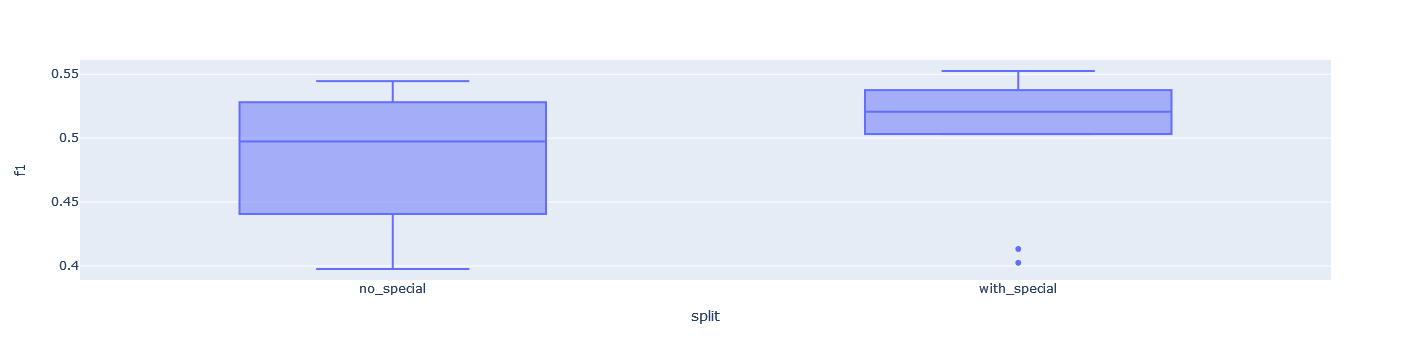

In [22]:
print(len(scores['elsherief2021']['hegsplits']['with_special'].loc['f1-score', 'True']))
f1s = {}
for split in ['no_special', 'with_special']:
    f1s[split] = scores['elsherief2021']['hegsplits'][split].loc['f1-score', 'True']
    # print(f1s[split])

# Boxplot of hegsplits vs controlsplits

f1_df = pd.concat([f1s['no_special'], f1s['with_special']], keys=['no_special', 'with_special'], names=['split', 'old_index']).reset_index(level='split').reset_index(drop=True).rename(columns={'True': 'f1'})

import plotly.express as px

px.box(f1_df, x='split', y='f1')

10


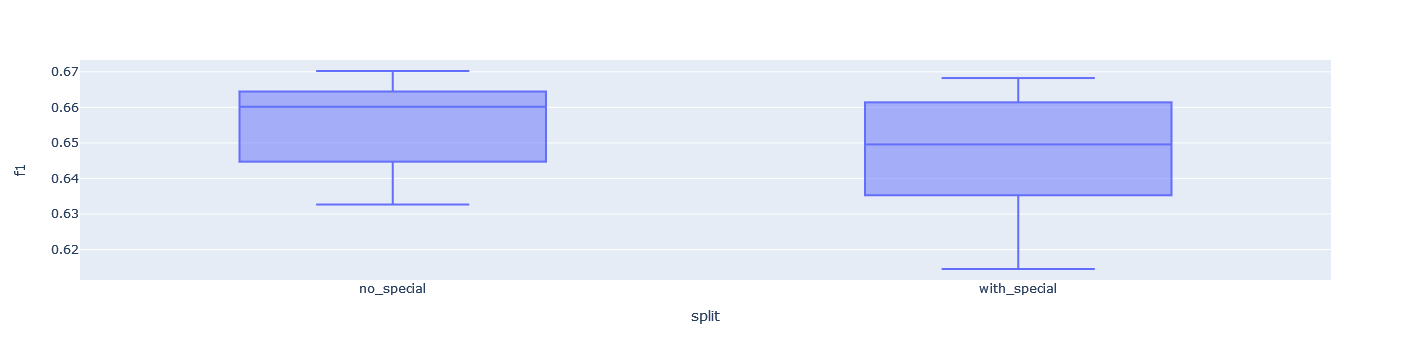

In [25]:
dataset = 'sbic'
print(len(scores[dataset]['hegsplits']['with_special'].loc['f1-score', 'True']))
f1s = {}
for split in ['no_special', 'with_special']:
    f1s[split] = scores[dataset]['hegsplits'][split].loc['f1-score', 'True']
    # print(f1s[split])

# Boxplot of hegsplits vs controlsplits

f1_df = pd.concat([f1s['no_special'], f1s['with_special']], keys=['no_special', 'with_special'], names=['split', 'old_index']).reset_index(level='split').reset_index(drop=True).rename(columns={'True': 'f1'})

import plotly.express as px

px.box(f1_df, x='split', y='f1')

In [26]:
from scipy.stats import ttest_rel
ttest_rel(f1s['no_special'], f1s['with_special'])

Ttest_relResult(statistic=0.9127665141299659, pvalue=0.3851636981254888)

## Between classifiers

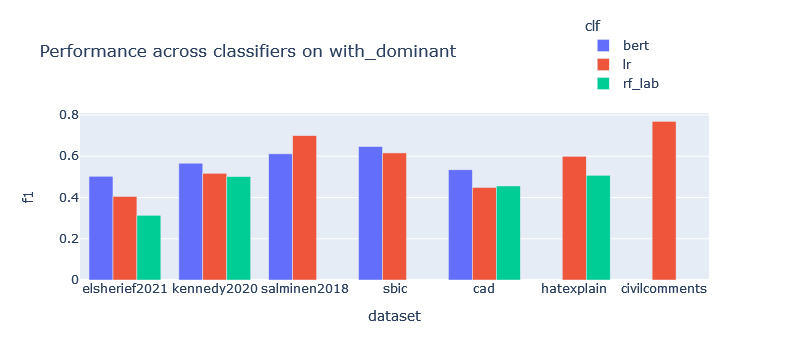

In [28]:
import os
import pandas as pd
import plotly.express as px
from IPython.display import display

clfs = [('bert', 5), ('lr', 5), ('rf_lab', 1)] # (clf_name, cv_runs)
# base_dirpath = '/storage2/mamille3/hegemonic_hate'
base_dirpath = '/home/mamille3/hegemonic_hate/output'

titles = {'hegsplits': 'With_dominant vs no_dominant',
          'controlsplits': 'With_control vs no_control'}
scores_dict = {}
# for splits in ['hegsplits', 'controlsplits']:
for clf_name, cv_runs in clfs:
    for splits in ['hegsplits']:

        name = os.path.join(base_dirpath, f'{clf_name}_{cv_runs}x2cv_f1.csv')

        # Load scores
        if clf_name == 'rf_lab':
            dataset_scores = []
            for dataset in ['elsherief2021', 'cad', 'kennedy2020', 'hatexplain']:
                # scores_path = f'/storage2/mamille3/josh_hate_speech_classifier/output/perf_{dataset}_RF.csv'
                scores_path = os.path.join(base_dirpath, f'perf_{dataset}_RF.csv')
                scores = pd.read_csv(scores_path)
                if not 'split' in scores.columns:
                    scores['split'] = 'with_special'
                if not 'splits' in scores.columns:
                    scores['splits'] = 'hegsplits' # ran this on hegsplits
                dataset_scores.append(scores[['dataset', 'splits', 'split', 'f1']])
            f1s = pd.concat(dataset_scores)
        else:
            scores_path = name
            f1s = pd.read_csv(scores_path, index_col=0)
        if splits == 'hegsplits':
            if 'splits' in f1s.columns:
                f1s = f1s.query('splits == @splits')
            f1s = f1s.replace('with_special', 'with_dominant').replace('no_special', 'no_dominant')
        elif splits == 'controlsplits':
            f1s = f1s.replace('with_special', 'with_control').replace('no_special', 'no_control')
        f1s['clf'] = clf_name
        scores_dict[(clf_name, cv_runs)] = f1s

scores = pd.concat(scores_dict.values())
scores

# Plot
selection = 'with_dominant'
fig = px.bar(scores.query('split == @selection'), x='dataset', y='f1', color='clf', barmode='group', 
             title=f'Performance across classifiers on {selection}')
fig.update_layout(legend=dict(
    yanchor='top',
    y=1.6,
    xanchor='left',
    x=0.8
))
fig.show()

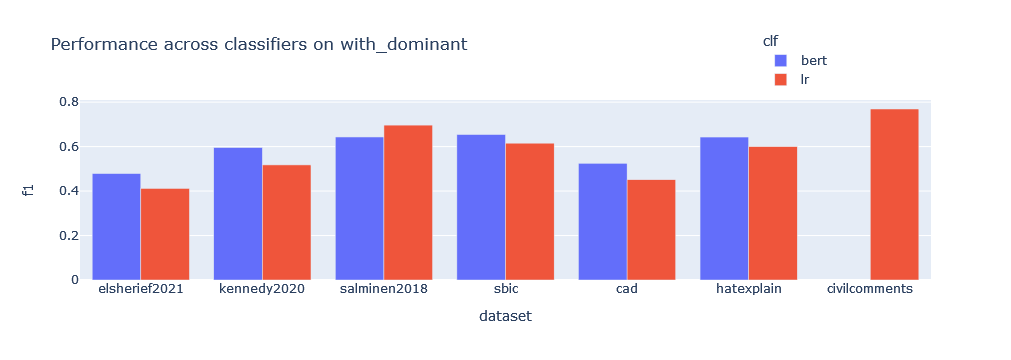

In [9]:
# Plot
selection = 'with_dominant'
fig = px.bar(scores.query('split == @selection'), x='dataset', y='f1', color='clf', barmode='group', 
             title=f'Performance across classifiers on {selection}')
fig.update_layout(legend=dict(
    yanchor='top',
    y=1.4,
    xanchor='left',
    x=0.8
))
fig.show()

# Visualize cross-identity results

In [10]:
# Load scores
import pandas as pd

scores_path = '../output/combined_identity_bert_scores_kennedy2020+sbic+hatexplain+civilcomments.csv'
scores = pd.read_csv(scores_path, index_col='train_dataset')
scores = scores.drop(columns='people of color').drop('people of color')
scores = scores.rename(columns={'muslims and arabic/middle eastern people': 'muslims, arabs'})
scores = scores.rename(index={'muslims and arabic/middle eastern people': 'muslims, arabs'})

# Shade by value
import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)
pd.set_option('display.max_colwidth', 1000)
scores.style.background_gradient(cmap=cm)

,asian people,black people,christians,jews,latinx people,lgbtq+ people,men,"muslims, arabs",white people,women
train_dataset,,,,,,,,,,
asian people,0.716742,0.450302,0.357751,0.390606,0.554656,0.290876,0.338501,0.427700,0.526178,0.305620
black people,0.311111,0.758290,0.234568,0.276547,0.463912,0.208534,0.269085,0.223176,0.483092,0.255336
christians,0.306690,0.325068,0.635258,0.472381,0.335855,0.405558,0.375427,0.402996,0.319355,0.285392
jews,0.227937,0.168371,0.392484,0.815131,0.227954,0.226501,0.215638,0.307995,0.248092,0.146778
latinx people,0.384034,0.432943,0.261603,0.333094,0.700119,0.208311,0.236741,0.281284,0.567647,0.205344
lgbtq+ people,0.169673,0.237193,0.375242,0.348442,0.200808,0.772549,0.510111,0.217159,0.202532,0.397130
men,0.382917,0.478561,0.407407,0.403618,0.376295,0.630672,0.592271,0.380872,0.455243,0.508521
"muslims, arabs",0.414724,0.364802,0.443623,0.519337,0.420248,0.305642,0.329986,0.775807,0.379747,0.304095
white people,0.320475,0.403383,0.291417,0.225619,0.383985,0.190510,0.275510,0.175400,0.720195,0.204840
